# Harness Real-World Data: URL Database (Harmless & Harmful Combined)

## Want some URLs? Here, have a Million. 🎁

### Overview

This notebook facilitates the creation of a large, labeled dataset of URLs by aggregating data from various reliable, open-source platforms. This dataset is invaluable for testing and training purposes in Phishing URL detections.

Data Sources:
- URLHaus: Known for its extensive collection of URLs associated with malware and other threats.
- PhishStats: Specializes in tracking phishing URLs.
- CommonCrawl: Provides a vast dataset of harmless URLs, ensuring balanced data for testing.

Data Collection Date: 2024
Note: If you are using this after 2024, please verify the links for updates as URLs and datasets may have changed.

### License and Usage

This project is released under a permissive license. You are free to use, modify, and distribute this work as you see fit, without any restrictions. However, attribution is appreciated.

Run this entire code to automatically generate a CSV file containing more than 1 million URLs. Each URL in the database is meticulously labeled with categories such as Harmless, Likely Malicious, Suspicious, Phishing, Definitely Phishing, Malware, and Unknown.

Note on URL Quantity and Ratio:

The number of URLs in the database can be adjusted according to your needs. The dataset of harmful URLs is limited due to the fixed output from reliable sources like URLHaus and PhishStats. However, for harmless URLs gathered from Common Crawl, you have the flexibility to collect more data by adjusting the number of WAT files to download and extract.

- Balanced Ratio (1:1): If you want a balanced ratio of harmful to harmless URLs (1:1), setting the number of WAT files to 5 will yield approximately 300,000 URLs for each category. This provides a well-balanced dataset for testing scenarios where equal representation is important.

- Optimal Large Dataset (2:1): For an optimal dataset with around 1 million URLs, setting the number of WAT files to 10 is recommended. This will result in a ratio of approximately 2:1, where the harmless URLs will be double the harmful ones. Specifically, you'll have around 325,788 harmful URLs and 787,152 harmless URLs, giving you a total of approximately 1,112,940 URLs.

If you require an even larger dataset, you can further increase the number of WAT files, but be aware that this will significantly increase the data size, download time, and processing load on your machine. The 1 million URL dataset is considered optimal for most use cases.



## Import

In [1]:
import requests
import zipfile
import os
import pandas as pd
import logging
import json
import gzip
from IPython.display import display

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


## Functions

In [2]:
def download_and_extract_zip(url, zip_filename, extract_to="."):
    try:
        # Download the ZIP file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the ZIP file
        with open(zip_filename, 'wb') as zip_file:
            for chunk in response.iter_content(chunk_size=8192):
                zip_file.write(chunk)
        print(f"ZIP file downloaded successfully as {zip_filename}")
        
        # Extract the ZIP file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"ZIP file extracted successfully. Extracted files: {zip_ref.namelist()}")

        # Optionally, remove the ZIP file after extraction
        os.remove(zip_filename)
        print(f"ZIP file {zip_filename} removed after extraction.")

    except requests.exceptions.RequestException as e:
        print(f"Failed to download the ZIP file. Error: {e}")
    except zipfile.BadZipFile as e:
        print(f"Failed to extract the ZIP file. It may be corrupted. Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [3]:
# Define a function to categorize the scores
def label_phishing(score):
    if 0 <= score < 2:
        return 'Likely'
    elif 2 <= score < 4:
        return 'Suspicious'
    elif 4 <= score < 6:
        return 'Phishing'
    elif 6 <= score <= 10:
        return 'Definitely Phishing'
    else:
        return 'Unknown'

In [4]:
def download_file(url, local_filename):
    """Download a file from a URL and save it locally."""
    try:
        logging.info(f"Starting download from {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad responses
        with open(local_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        logging.info(f"File downloaded successfully as {local_filename}")
    except requests.exceptions.RequestException as e:
        logging.error(f"Error downloading the file: {e}")
        return False
    return True

In [5]:
def extract_wat_paths(gz_filename):
    """Extract the WAT paths from a gzipped file and prompt the user for how many to display."""
    try:
        logging.info(f"Extracting WAT paths from {gz_filename}")
        with gzip.open(gz_filename, 'rt') as f:
            wat_paths = f.read().splitlines()
        
        # Display the total number of WAT paths found
        total_paths = len(wat_paths)
        logging.info(f"Total WAT paths found: {total_paths}")
        
        # Prompt the user for how many WAT paths to display
        display_count = int(input("Enter the number of WAT paths you would like to display -- Recommend 10 -- (Warning: Displaying too many may slow down your machine): "))
        
        # Display the specified number of WAT paths
        logging.info(f"First {display_count} WAT paths: {wat_paths[:display_count]}")
        return wat_paths
    except Exception as e:
        logging.error(f"Error extracting WAT paths: {e}")
        return []

In [6]:
def download_wat_files(wat_paths, download_count):
    """Download a specified number of WAT files from the given paths."""
    # Directory to store the downloaded WAT files
    os.makedirs('wat_files', exist_ok=True)

    try:
        for i, wat_file_path in enumerate(wat_paths[:download_count]):
            wat_file_url = f"https://data.commoncrawl.org/{wat_file_path}"
            wat_file_name = os.path.join('wat_files', wat_file_path.split('/')[-1])
            
            # Download the WAT file
            logging.info(f"Downloading {wat_file_url}")
            response = requests.get(wat_file_url)
            response.raise_for_status()  # Raise an error for bad responses

            # Save the WAT file
            with open(wat_file_name, 'wb') as f:
                f.write(response.content)
            
            logging.info(f"Downloaded {wat_file_name}")

        logging.info(f"Successfully downloaded {download_count} WAT files.")
    
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to download WAT files: {e}")
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")

In [7]:
# Function to extract URLs from a WAT file
def extract_urls_from_wat(wat_file):
    urls = []
    malformed_lines_count = 0
    with gzip.open(wat_file, 'rt', encoding='utf-8') as f:
        for line in f:
            try:
                record = json.loads(line)
                if 'Envelope' in record and 'WARC-Target-URI' in record['Envelope']['WARC-Header-Metadata']:
                    urls.append(record['Envelope']['WARC-Header-Metadata']['WARC-Target-URI'])
            except json.JSONDecodeError:
                malformed_lines_count += 1
                continue
    return urls, malformed_lines_count

# I. Retrieve Harmful URLs

## a. Data from URLHaus

In [8]:
# URL of the full database dump ZIP file
url = "https://urlhaus.abuse.ch/downloads/csv/"
zip_filename = "urlhaus_full_dump.zip"
csv_filename = "urlhaus_full_dump.csv"

# Call the function to download and extract the ZIP file
download_and_extract_zip(url, zip_filename)

ZIP file downloaded successfully as urlhaus_full_dump.zip
ZIP file extracted successfully. Extracted files: ['csv.txt']
ZIP file urlhaus_full_dump.zip removed after extraction.


In [9]:
# Path to the unzipped text file
txt_filename = 'csv.txt'

# Check if the file exists before proceeding
if os.path.exists(txt_filename):
    try:
        # Load the text file into a DataFrame
        # Skip the initial lines that contain metadata information (usually around 6-7 lines)
        df = pd.read_csv(txt_filename, skiprows=8, delimiter=',')

        # Define the output CSV filename
        csv_filename = 'URLHaus_dump.csv'

        # Save the DataFrame to a CSV file
        df.to_csv(csv_filename, index=False)

        print(f"File saved as {csv_filename}")

        # Delete the original text file after conversion
        os.remove(txt_filename)
        print(f"Original text file {txt_filename} deleted successfully.")
        
    except pd.errors.EmptyDataError:
        print(f"Error: {txt_filename} is empty or has no valid data.")
    except pd.errors.ParserError as e:
        print(f"Error parsing {txt_filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print(f"Error: The file {txt_filename} does not exist.")


File saved as URLHaus_dump.csv
Original text file csv.txt deleted successfully.


In [10]:
# Load the CSV file into a DataFrame
df = pd.read_csv('URLHaus_dump.csv')

# Display the first few rows to confirm the data is loaded correctly
print("✅ CSV file loaded successfully! Below are the first few rows of the data:")

# Styled display of the first few rows of the DataFrame
styled_df = df.head(10).style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#2c3e50'), 
                                        ('color', 'white'), 
                                        ('font-weight', 'bold'), 
                                        ('border', '1px solid #ccc')]},
     {'selector': 'tbody td', 'props': [('background-color', '#ecf0f1'),
                                        ('color', '#2c3e50'),
                                        ('border', '1px solid #ccc')]}]
).set_properties(
    **{'text-align': 'left', 'padding': '10px'}
)

styled_df

✅ CSV file loaded successfully! Below are the first few rows of the data:


,# id,dateadded,url,url_status,last_online,threat,tags,urlhaus_link,reporter
0,3154181,2024-09-03 06:22:39,http://80.76.176.23/kali-live.iso,online,2024-09-03 06:22:39,malware_download,None,https://urlhaus.abuse.ch/url/3154181/,lontze7
1,3154180,2024-09-03 06:10:24,http://80.76.176.23/wlu.iso,online,2024-09-03 06:10:24,malware_download,None,https://urlhaus.abuse.ch/url/3154180/,lontze7
2,3154179,2024-09-03 06:09:43,http://193.149.176.152:9999/update.dll,online,2024-09-03 06:09:43,malware_download,None,https://urlhaus.abuse.ch/url/3154179/,s1dhy
3,3154178,2024-09-03 06:09:38,http://193.149.176.152:9999/upgrade.exe,offline,nan,malware_download,None,https://urlhaus.abuse.ch/url/3154178/,s1dhy
4,3154177,2024-09-03 06:09:36,http://80.76.176.23/mimi.iso,online,2024-09-03 06:09:36,malware_download,None,https://urlhaus.abuse.ch/url/3154177/,lontze7
5,3154176,2024-09-03 06:09:35,http://80.76.176.23/kswapd0,online,2024-09-03 06:09:35,malware_download,None,https://urlhaus.abuse.ch/url/3154176/,lontze7
6,3154175,2024-09-03 06:09:33,http://156.248.75.245/xiezhenhaokan.apk,online,2024-09-03 06:09:33,malware_download,"apk ,opendir,SpyNote",https://urlhaus.abuse.ch/url/3154175/,nci
7,3154174,2024-09-03 06:09:32,http://156.248.77.92/%e5%af%ab%e7%9c%9f(1).apk,online,2024-09-03 06:09:32,malware_download,"apk ,opendir,SpyNote",https://urlhaus.abuse.ch/url/3154174/,nci
8,3154171,2024-09-03 06:09:28,https://156.248.75.237/ready3.apk,online,2024-09-03 06:09:28,malware_download,"apk ,opendir,SpyNote",https://urlhaus.abuse.ch/url/3154171/,nci
9,3154172,2024-09-03 06:09:28,http://156.248.77.50/%e5%af%ab%e7%9c%9f1111.apk,online,2024-09-03 06:09:28,malware_download,"apk ,opendir,SpyNote",https://urlhaus.abuse.ch/url/3154172/,nci


In [11]:
# Drop unnecessary columns
columns_to_drop = ['# id', 'reporter', 'threat', 'tags', 'urlhaus_link', 'last_online']
df_cleaned = df.drop(columns=columns_to_drop)

# Rename the columns
df_cleaned.columns = ['Date_Added', 'URL', 'URL_Status']

# Add a column to label these URLs as harmful
df_cleaned['Label'] = 'Malware'

# Display the first few rows with the styled table
styled_df_cleaned = df_cleaned.head().style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody td', 'props': [('background-color', '#ecf0f1'), ('color', '#2c3e50'), ('border', '1px solid #ccc'), ('padding', '10px'), ('text-align', 'left')]}]
)

styled_df_cleaned


,Date_Added,URL,URL_Status,Label
0,2024-09-03 06:22:39,http://80.76.176.23/kali-live.iso,online,Malware
1,2024-09-03 06:10:24,http://80.76.176.23/wlu.iso,online,Malware
2,2024-09-03 06:09:43,http://193.149.176.152:9999/update.dll,online,Malware
3,2024-09-03 06:09:38,http://193.149.176.152:9999/upgrade.exe,offline,Malware
4,2024-09-03 06:09:36,http://80.76.176.23/mimi.iso,online,Malware


In [12]:
# Check the size of the dataset
print(f"Data size from URLHaus: {df_cleaned.shape[0]}")

Data size from URLHaus: 278626


In [13]:
# Save the cleaned data to a new CSV file
cleaned_csv_filename = 'URLHAUS_Cleaned_Data.csv'
df_cleaned.to_csv(cleaned_csv_filename, index=False)

print(f"Cleaned data saved as {cleaned_csv_filename}")

# Remove the previous CSV file
# If you want to keep the original CSV dump, comment out the code below.
previous_csv_filename = 'URLHaus_dump.csv'
if os.path.exists(previous_csv_filename):
    os.remove(previous_csv_filename)
    print(f"Previous file {previous_csv_filename} has been removed.")
else:
    print(f"No file named {previous_csv_filename} found.")


Cleaned data saved as URLHAUS_Cleaned_Data.csv
Previous file URLHaus_dump.csv has been removed.


# b. Data from Phishstats

In [19]:
# URL of the PhishStats CSV file
url = 'https://phishstats.info/phish_score.csv'

# Download the CSV file
response = requests.get(url)
csv_filename = 'phishstats_data.csv'

# Save the CSV file
with open(csv_filename, 'wb') as file:
    file.write(response.content)

print(f"PhishStats data downloaded successfully as {csv_filename}")


PhishStats data downloaded successfully as phishstats_data.csv


In [20]:
# Define the file path
csv_filename = 'phishstats_data.csv' 

# Skip the first few rows of metadata and load the CSV
df_phishstats = pd.read_csv(csv_filename, skiprows=9, header=None)

# Display the first few rows to check
styled_df = df_phishstats.head().style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#ecf0f1')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]},
    {'selector': 'td', 'props': [('border', '1px solid #ccc'), ('padding', '10px')]},
    {'selector': 'thead th, td', 'props': [('text-align', 'left')]}
])

styled_df


,0,1,2,3
0,2024-09-03 02:35:29,1.900000,https://metamalklogin.gitbook.io/us,2606:4700:4400::ac40:93d1
1,2024-09-03 02:32:54,1.900000,https://matixmusk-logzn.gitbook.io/us,172.64.147.209
2,2024-09-03 02:30:59,1.400000,https://mastmskk-loggim.gitbook.io/us,172.64.147.209
3,2024-09-03 02:30:39,2.400000,https://maitemasklogin.gitbook.io/us,172.64.147.209
4,2024-09-03 02:25:36,5.800000,https://google.com/amp/s/pub-513415bbbd6d43e39e7853abbe68ca5a.r2.dev/jj.html#info@mup.cz,2607:f8b0:4006:816::200e


In [21]:
import pandas as pd

# Define the file path
csv_filename = 'phishstats_data.csv'  # Replace with your actual file path

# Skip the first few rows of metadata and load the CSV
df_phishstats = pd.read_csv(csv_filename, skiprows=9, header=None)

# Rename the columns
df_phishstats.columns = ['Date_Added', 'Score', 'URL', 'IP']

# Drop rows with any missing values
df_phishstats.dropna(inplace=True)


# Display the DataFrame to verify
styled_df = df_phishstats.head().style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#ecf0f1')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]},
    {'selector': 'td', 'props': [('border', '1px solid #ccc'), ('padding', '10px')]},
    {'selector': 'thead th, td', 'props': [('text-align', 'left')]}
])

styled_df


,Date_Added,Score,URL,IP
0,2024-09-03 02:35:29,1.900000,https://metamalklogin.gitbook.io/us,2606:4700:4400::ac40:93d1
1,2024-09-03 02:32:54,1.900000,https://matixmusk-logzn.gitbook.io/us,172.64.147.209
2,2024-09-03 02:30:59,1.400000,https://mastmskk-loggim.gitbook.io/us,172.64.147.209
3,2024-09-03 02:30:39,2.400000,https://maitemasklogin.gitbook.io/us,172.64.147.209
4,2024-09-03 02:25:36,5.800000,https://google.com/amp/s/pub-513415bbbd6d43e39e7853abbe68ca5a.r2.dev/jj.html#info@mup.cz,2607:f8b0:4006:816::200e


In [22]:
# Apply the function to create a new column 'Label'
df_phishstats['Label'] = df_phishstats['Score'].apply(label_phishing)

# Display the updated DataFrame with the new 'Label' column

styled_df = df_phishstats.head().style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#ecf0f1')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]},
    {'selector': 'td', 'props': [('border', '1px solid #ccc'), ('padding', '10px')]},
    {'selector': 'thead th, td', 'props': [('text-align', 'left')]}
])

styled_df

,Date_Added,Score,URL,IP,Label
0,2024-09-03 02:35:29,1.900000,https://metamalklogin.gitbook.io/us,2606:4700:4400::ac40:93d1,Likely
1,2024-09-03 02:32:54,1.900000,https://matixmusk-logzn.gitbook.io/us,172.64.147.209,Likely
2,2024-09-03 02:30:59,1.400000,https://mastmskk-loggim.gitbook.io/us,172.64.147.209,Likely
3,2024-09-03 02:30:39,2.400000,https://maitemasklogin.gitbook.io/us,172.64.147.209,Suspicious
4,2024-09-03 02:25:36,5.800000,https://google.com/amp/s/pub-513415bbbd6d43e39e7853abbe68ca5a.r2.dev/jj.html#info@mup.cz,2607:f8b0:4006:816::200e,Phishing


In [23]:
# Check the number of rows in the DataFrame
num_rows_phishstats = df_phishstats.shape[0]
print(f"Data size in phishstats: {num_rows_phishstats}")

Data size in phishstats: 46015


In [24]:
# Save the cleaned DataFrame to a new CSV file
cleaned_csv_filename = 'Phishstats_Cleaned_Data.csv'
df_phishstats.to_csv(cleaned_csv_filename, index=False)

print(f"Cleaned PhishStats data saved as {cleaned_csv_filename}")

# Remove the previous CSV file
previous_csv_filename = 'phishstats_data.csv'
if os.path.exists(previous_csv_filename):
    os.remove(previous_csv_filename)
    print(f"Previous file {previous_csv_filename} has been removed.")
else:
    print(f"No file named {previous_csv_filename} found.")

# Note: If you want to keep the original CSV dump, just comment out the code for removing the previous file.


Cleaned PhishStats data saved as Phishstats_Cleaned_Data.csv
Previous file phishstats_data.csv has been removed.


# Combine Harmful URLs

In [25]:
# Combine the two DataFrames
combined_df = pd.concat([df_cleaned, df_phishstats])

# Sort the combined DataFrame by the 'Date_Added' column
combined_df = combined_df.sort_values(by='Date_Added', ascending=False)

# Define the table style
table_style = {
    'selector': 'thead th',
    'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]
}

# Apply the custom style and display the combined DataFrame
styled_table = combined_df.head().style.set_table_styles([table_style]).set_properties(
    **{'background-color': '#ecf0f1', 'color': '#2c3e50', 'border': '1px solid #ccc', 'text-align': 'left', 'padding': '10px'}
)

styled_table


,Date_Added,URL,URL_Status,Label,Score,IP
0,2024-09-03 06:22:39,http://80.76.176.23/kali-live.iso,online,Malware,nan,nan
1,2024-09-03 06:10:24,http://80.76.176.23/wlu.iso,online,Malware,nan,nan
2,2024-09-03 06:09:43,http://193.149.176.152:9999/update.dll,online,Malware,nan,nan
3,2024-09-03 06:09:38,http://193.149.176.152:9999/upgrade.exe,offline,Malware,nan,nan
4,2024-09-03 06:09:36,http://80.76.176.23/mimi.iso,online,Malware,nan,nan


In [26]:
# Drop the specified columns from the DataFrame
columns_to_drop = ['URL_Status', 'Score', 'IP', 'Date_Added']
df_final = combined_df.drop(columns=columns_to_drop)

# Define the table style
table_style = {
    'selector': 'thead th',
    'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]
}

# Apply the custom style and display the first few rows of the final DataFrame
styled_final_table = df_final.head().style.set_table_styles([table_style]).set_properties(
    **{'background-color': '#ecf0f1', 'color': '#2c3e50', 'border': '1px solid #ccc', 'text-align': 'left', 'padding': '10px'}
)

styled_final_table


,URL,Label
0,http://80.76.176.23/kali-live.iso,Malware
1,http://80.76.176.23/wlu.iso,Malware
2,http://193.149.176.152:9999/update.dll,Malware
3,http://193.149.176.152:9999/upgrade.exe,Malware
4,http://80.76.176.23/mimi.iso,Malware


In [27]:
# Check the number of rows in the DataFrame
num_rows = combined_df.shape[0]
print(f"Combined DataFrame size: {num_rows}")

Combined DataFrame size: 324641


In [28]:
# Save the combined and sorted DataFrame to a new CSV file
combined_csv_filename = 'combined_harmful_urls.csv'
df_final.to_csv(combined_csv_filename, index=False)

print(f"Combined and sorted harmful URLs data saved as {combined_csv_filename}")

# Files to be deleted
files_to_delete = ['Phishstats_Cleaned_Data.csv', 'URLHAUS_Cleaned_Data.csv']

# Delete the specified files
# If you want to keep the cleaned CSV files, comment out the following block of code
for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"File {file} has been removed.")
    else:
        print(f"No file named {file} found.")


Combined and sorted harmful URLs data saved as combined_harmful_urls.csv
File Phishstats_Cleaned_Data.csv has been removed.
File URLHAUS_Cleaned_Data.csv has been removed.


# Retrieve Harmless URLs

## Extracting URLs from Common Crawl

In [29]:
# Configuration
wat_paths_url = 'https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/wat.paths.gz'
wat_paths_filename = 'wat.paths.gz'

# Download the WAT paths file
if download_file(wat_paths_url, wat_paths_filename):
    logging.info(f"Downloaded {wat_paths_filename} successfully.")
else:
    logging.error("Failed to download the WAT paths file.")


2024-09-03 13:53:07,755 - INFO - Starting download from https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/wat.paths.gz
2024-09-03 13:53:08,829 - INFO - File downloaded successfully as wat.paths.gz
2024-09-03 13:53:08,831 - INFO - Downloaded wat.paths.gz successfully.


In [30]:
wat_paths = extract_wat_paths(wat_paths_filename)

2024-09-03 13:53:08,840 - INFO - Extracting WAT paths from wat.paths.gz
2024-09-03 13:53:08,888 - INFO - Total WAT paths found: 90000


Enter the number of WAT paths you would like to display -- Recommend 10 -- (Warning: Displaying too many may slow down your machine): 10


2024-09-03 13:53:12,621 - INFO - First 10 WAT paths: ['crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00000.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00001.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00002.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00003.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00004.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00005.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00006.warc.wat.gz', 'crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00007.warc.wat.gz', 'crawl-data/CC-MAIN-2024-3

In [31]:
download_count = int(input("Enter the number of WAT files you want to download -- Recommend 10 -- (Warning: Downloading too many files may result in large data sizes and slow processing): "))
download_wat_files(wat_paths, download_count)

Enter the number of WAT files you want to download -- Recommend 10 -- (Warning: Downloading too many files may result in large data sizes and slow processing): 10


2024-09-03 13:53:14,155 - INFO - Downloading https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00000.warc.wat.gz
2024-09-03 13:54:41,207 - INFO - Downloaded wat_files/CC-MAIN-20240802234508-20240803024508-00000.warc.wat.gz
2024-09-03 13:54:41,207 - INFO - Downloading https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00001.warc.wat.gz
2024-09-03 13:56:07,180 - INFO - Downloaded wat_files/CC-MAIN-20240802234508-20240803024508-00001.warc.wat.gz
2024-09-03 13:56:07,183 - INFO - Downloading https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/segments/1722640353668.0/wat/CC-MAIN-20240802234508-20240803024508-00002.warc.wat.gz
2024-09-03 13:57:32,898 - INFO - Downloaded wat_files/CC-MAIN-20240802234508-20240803024508-00002.warc.wat.gz
2024-09-03 13:57:32,900 - INFO - Downloading https://data.commoncrawl.org/crawl-data/CC-MAIN-2024-33/segments/17

In [32]:
# Directory where WAT files are stored
wat_files_directory = 'wat_files'

# Start extraction process
logging.info("Starting URL extraction from WAT files...")

all_urls = []
total_malformed_lines = 0

for wat_file_name in os.listdir(wat_files_directory):
    wat_file_path = os.path.join(wat_files_directory, wat_file_name)
    
    urls, malformed_lines_count = extract_urls_from_wat(wat_file_path)
    all_urls.extend(urls)
    total_malformed_lines += malformed_lines_count
    logging.info(f"Extracted {len(urls)} URLs from {wat_file_name} with {malformed_lines_count} malformed lines.")

logging.info(f"Total URLs extracted: {len(all_urls)}")
logging.warning(f"Total malformed JSON lines skipped: {total_malformed_lines}")

2024-09-03 14:07:53,558 - INFO - Starting URL extraction from WAT files...
2024-09-03 14:08:05,343 - INFO - Extracted 78510 URLs from CC-MAIN-20240802234508-20240803024508-00008.warc.wat.gz with 785127 malformed lines.
2024-09-03 14:08:16,936 - INFO - Extracted 78252 URLs from CC-MAIN-20240802234508-20240803024508-00001.warc.wat.gz with 782547 malformed lines.
2024-09-03 14:08:28,937 - INFO - Extracted 78759 URLs from CC-MAIN-20240802234508-20240803024508-00004.warc.wat.gz with 787617 malformed lines.
2024-09-03 14:08:40,713 - INFO - Extracted 78894 URLs from CC-MAIN-20240802234508-20240803024508-00007.warc.wat.gz with 788967 malformed lines.
2024-09-03 14:08:52,476 - INFO - Extracted 78696 URLs from CC-MAIN-20240802234508-20240803024508-00002.warc.wat.gz with 786987 malformed lines.
2024-09-03 14:09:04,295 - INFO - Extracted 78615 URLs from CC-MAIN-20240802234508-20240803024508-00005.warc.wat.gz with 786177 malformed lines.
2024-09-03 14:09:16,112 - INFO - Extracted 78750 URLs from CC

In [36]:
# Define the filename for the CSV
harmless_csv_filename = 'harmless_urls_commoncrawl.csv'

df_harmless_urls = pd.DataFrame({'URL': all_urls})
# Save the DataFrame to a CSV file
df_harmless_urls.to_csv(harmless_csv_filename, index=False)

print(f"Harmless URLs data saved as {harmless_csv_filename}")

# Delete the previous WAT files after extraction
wat_files_directory = 'wat_files'

for wat_file_name in os.listdir(wat_files_directory):
    wat_file_path = os.path.join(wat_files_directory, wat_file_name)
    try:
        os.remove(wat_file_path)
        print(f"Deleted {wat_file_name}")
    except Exception as e:
        print(f"Failed to delete {wat_file_name}: {e}")

# Optionally, you can remove the directory itself if it's empty
if not os.listdir(wat_files_directory):
    os.rmdir(wat_files_directory)
    print(f"Removed empty directory {wat_files_directory}")

# Delete the wat.paths.gz file after extraction
wat_paths_filename = 'wat.paths.gz'

if os.path.exists(wat_paths_filename):
    try:
        os.remove(wat_paths_filename)
        print(f"Deleted {wat_paths_filename}")
    except Exception as e:
        print(f"Failed to delete {wat_paths_filename}: {e}")
else:
    print(f"No file named {wat_paths_filename} found.")


Harmless URLs data saved as harmless_urls_commoncrawl.csv
Deleted CC-MAIN-20240802234508-20240803024508-00008.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00001.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00004.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00007.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00002.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00005.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00000.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00009.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00003.warc.wat.gz
Deleted CC-MAIN-20240802234508-20240803024508-00006.warc.wat.gz
Removed empty directory wat_files
Deleted wat.paths.gz


In [37]:
# Concatenate the first 5 and last 5 entries
first_5 = df_harmless_urls.head(5)
last_5 = df_harmless_urls.tail(5)
combined_df = pd.concat([first_5, last_5])

# Display the concatenated DataFrame with the custom table style
display(combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('background-color', '#ecf0f1'), ('color', '#2c3e50'), ('border', '1px solid #ccc'), ('padding', '10px')]},
    {'selector': 'tbody tr:hover td', 'props': [('background-color', '#d1e7dd')]},
]))


,URL
0,http://02234.cc/index.php/voddetail69008.html
1,http://02234.cc/index.php/voddetail69008.html
2,http://02234.cc/index.php/voddetail69008.html
3,http://03dev.com/voddetail/435588.html
4,http://03dev.com/voddetail/435588.html
787147,https://zygrib.org/forum/ucp.php?mode=privacy&sid=b37ffae204825332e6ccbb08e766bcc2
787148,https://zygrib.org/forum/ucp.php?mode=privacy&sid=b37ffae204825332e6ccbb08e766bcc2
787149,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html
787150,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html
787151,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html


## Verify and sanitize the extracted data to ensure the exclusion of any harmful URLs.

In [38]:
# Load the CSV file containing harmful URLs
harmful_urls_df = pd.read_csv('combined_harmful_urls.csv')  # Adjust the filename as needed

# Convert the harmful URLs column into a set for efficient look-up
harmful_urls_set = set(harmful_urls_df['URL'])

# Filter the harmless URLs DataFrame by excluding any URLs found in the harmful set
df_harmless_cleaned = df_harmless_urls[~df_harmless_urls['URL'].isin(harmful_urls_set)]

# Calculate the number of URLs removed and print the summary
urls_removed = len(df_harmless_urls) - len(df_harmless_cleaned)
print(f"Removed {urls_removed} harmful URLs from the harmless dataset.")
print(f"Final count of harmless URLs: {len(df_harmless_cleaned)}")


Removed 0 harmful URLs from the harmless dataset.
Final count of harmless URLs: 787152


In [39]:
# Add a new column "Label" and set its value to "Harmless"
df_harmless_cleaned['Label'] = 'Harmless'

In [40]:
# Save the cleaned harmless URLs to a new CSV file
cleaned_harmless_csv_filename = 'Cleaned_Harmless_urls_commoncrawl.csv'
df_harmless_cleaned.to_csv(cleaned_harmless_csv_filename, index=False)

print(f"Cleaned harmless URLs data saved as {cleaned_harmless_csv_filename}")

# Remove the previous CSV file
previous_harmless_csv_filename = 'harmless_urls_commoncrawl.csv'
if os.path.exists(previous_harmless_csv_filename):
    os.remove(previous_harmless_csv_filename)
    print(f"Previous file {previous_harmless_csv_filename} has been removed.")
else:
    print(f"No file named {previous_harmless_csv_filename} found.")


Cleaned harmless URLs data saved as Cleaned_Harmless_urls_commoncrawl.csv
Previous file harmless_urls_commoncrawl.csv has been removed.


In [41]:
# Combine the first 5 and last 5 rows into a single DataFrame
combined_rows = pd.concat([df_harmless_cleaned.head(5), df_harmless_cleaned.tail(5)])

# Display the combined rows as a styled table
styled_table = combined_rows.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold'), ('padding', '10px')]},
     {'selector': 'tbody td', 'props': [('background-color', '#ecf0f1'), ('color', '#2c3e50'), ('border', '1px solid #ccc'), ('text-align', 'left'), ('padding', '10px')]}]
).set_properties(**{
    'text-align': 'left',
    'padding': '10px'
})

styled_table


,URL,Label
0,http://02234.cc/index.php/voddetail69008.html,Harmless
1,http://02234.cc/index.php/voddetail69008.html,Harmless
2,http://02234.cc/index.php/voddetail69008.html,Harmless
3,http://03dev.com/voddetail/435588.html,Harmless
4,http://03dev.com/voddetail/435588.html,Harmless
787147,https://zygrib.org/forum/ucp.php?mode=privacy&sid=b37ffae204825332e6ccbb08e766bcc2,Harmless
787148,https://zygrib.org/forum/ucp.php?mode=privacy&sid=b37ffae204825332e6ccbb08e766bcc2,Harmless
787149,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html,Harmless
787150,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html,Harmless
787151,https://zyrixe.pp.ua/zokubishi/jak-plesti-kosichki-samij-sobi-poetapno.html,Harmless


# Combine both Harmful and Harmless

In [42]:
# Specify the data types for each column to ensure consistent loading
dtype_spec = {
    'URL': str,
    'Label': str
}

# Load the cleaned harmful and harmless URLs into DataFrames
df_harmful_cleaned = pd.read_csv('combined_harmful_urls.csv', dtype=dtype_spec, low_memory=False)
df_harmless_cleaned = pd.read_csv('Cleaned_Harmless_urls_commoncrawl.csv', dtype=dtype_spec, low_memory=False)

# Count the number of harmful and harmless URLs
num_harmful = df_harmful_cleaned.shape[0]
num_harmless = df_harmless_cleaned.shape[0]

print(f"Number of harmful URLs: {num_harmful}")
print(f"Number of harmless URLs: {num_harmless}")

# Combine the harmful and harmless DataFrames into one
df_combined = pd.concat([df_harmful_cleaned, df_harmless_cleaned])

# Count the total number of URLs after combining
total_urls = df_combined.shape[0]
print(f"Total number of URLs after combining: {total_urls}")

# Save the combined DataFrame to a new CSV file
final_csv_filename = 'TestData_Harmful_and_Harmless_URLs.csv'
df_combined.to_csv(final_csv_filename, index=False)

print(f"Combined harmful and harmless URLs data saved as {final_csv_filename}")

# Delete the individual CSV files after combining
# Note: If you want to keep the original individual CSV files (e.g., for backup or further analysis),
# you can comment out or remove the following block of code.

files_to_delete = ['combined_harmful_urls.csv', 'Cleaned_Harmless_urls_commoncrawl.csv']

for file in files_to_delete:
    if os.path.exists(file):
        try:
            os.remove(file)
            print(f"Deleted {file}")
        except Exception as e:
            print(f"Failed to delete {file}: {e}")
    else:
        print(f"No file named {file} found.")


Number of harmful URLs: 324641
Number of harmless URLs: 787152
Total number of URLs after combining: 1111793
Combined harmful and harmless URLs data saved as TestData_Harmful_and_Harmless_URLs.csv
Deleted combined_harmful_urls.csv
Deleted Cleaned_Harmless_urls_commoncrawl.csv


In [43]:
# Randomize the rows in the DataFrame
df_randomized = df_combined.sample(frac=1).reset_index(drop=True)

# Save the randomized DataFrame to a new CSV file
randomized_csv_filename = 'Randomized_TestData_Harmful_and_Harmless_URLs.csv'
df_randomized.to_csv(randomized_csv_filename, index=False)

print(f"Randomized harmful and harmless URLs data saved as {randomized_csv_filename}")

# Optionally delete the combined CSV file after randomizing
# Note: If you want to keep the original combined CSV file (e.g., for backup or further analysis),
# you can comment out or remove the following block of code.

combined_csv_filename = 'TestData_Harmful_and_Harmless_URLs.csv'

if os.path.exists(combined_csv_filename):
    try:
        os.remove(combined_csv_filename)
        print(f"Deleted {combined_csv_filename}")
    except Exception as e:
        print(f"Failed to delete {combined_csv_filename}: {e}")
else:
    print(f"No file named {combined_csv_filename} found.")

# Combine the first 5 and last 5 rows into a single DataFrame
combined_rows = pd.concat([df_randomized.head(5), df_randomized.tail(5)])

# Display the combined rows as a colorful table with your preferred style
styled_table = combined_rows.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('background-color', '#ecf0f1'), ('color', '#2c3e50'), ('padding', '10px'), ('border', '1px solid #ccc')]}
]).set_properties(**{
    'text-align': 'left',
})

styled_table


Randomized harmful and harmless URLs data saved as Randomized_TestData_Harmful_and_Harmless_URLs.csv
Deleted TestData_Harmful_and_Harmless_URLs.csv


,URL,Label
0,https://autopartsandequipment.com/tag/bluetec/,Harmless
1,http://42.226.66.30:52165/Mozi.m,Malware
2,http://mail.sitefind.top:8888/22509121009108.dll,Malware
3,https://www.register-yacht-seychelles.com/de/boat-insurance.html,Harmless
4,https://www.bwjunior.hants.sch.uk/about-the-school/school-history/1993,Harmless
1111788,https://secure04chase-git-main-gaxz123s-projects.vercel.app/index.html,Phishing
1111789,https://jfhisiifgyuhjiu477.weeblysite.com/,Phishing
1111790,http://tvietnam.com/bbs/board.php?bo_table=a01&wr_id=746,Harmless
1111791,https://customavto.ru/kak-zaregistrirovatsja-v-kraken.html,Harmless
1111792,https://www.go-on-film.com/yingnanchaozhong/3982115.html,Harmless


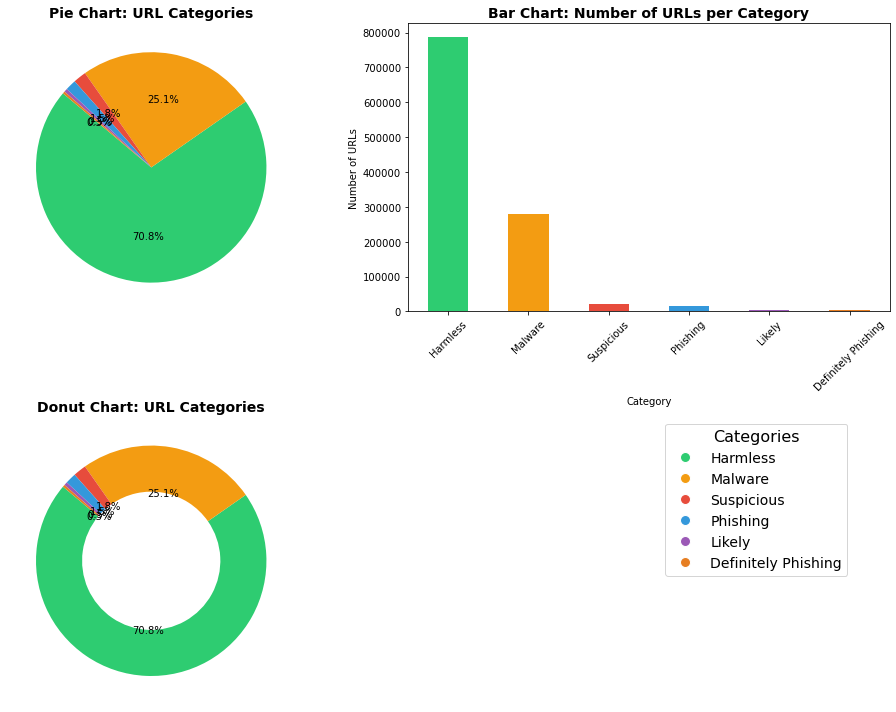

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each category in the 'Label' column
category_counts = df_randomized['Label'].value_counts()

# Define the colors
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#3498db', '#9b59b6', '#e67e22', '#34495e']

# Set up the 2x2 grid layout with only 3 active plots and space for the legend
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.delaxes(axs[1, 1])  # Remove the bottom-right empty plot

# Pie Chart
axs[0, 0].pie(category_counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors)
axs[0, 0].set_title('Pie Chart: URL Categories', fontsize=14, fontweight='bold')

# Bar Chart
category_counts.plot(kind='bar', color=colors, ax=axs[0, 1])
axs[0, 1].set_title('Bar Chart: Number of URLs per Category', fontsize=14, fontweight='bold')
axs[0, 1].set_xlabel('Category')
axs[0, 1].set_ylabel('Number of URLs')
axs[0, 1].tick_params(axis='x', rotation=45)

# Donut Chart
axs[1, 0].pie(category_counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.4))
axs[1, 0].set_title('Donut Chart: URL Categories', fontsize=14, fontweight='bold')

# Adding the legend in the bottom-right corner with larger font size
labels = list(category_counts.index)
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) 
           for label, color in zip(labels, colors)]
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.85, 0.3), title="Categories", fontsize=14, title_fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


# 🌟 **Category Counts Summary** 🌟

Below is a breakdown of the number of URLs in each category:

---



In [45]:
# Count the occurrences of each category in the 'Label' column
category_counts = df_randomized['Label'].value_counts()

# Stylish print of the category counts
print("\n" + "="*60)
print("🌟 Category Counts Summary 🌟".center(60, " "))
print("="*60 + "\n")

for category, count in category_counts.items():
    print(f"**{category}:** `{count}`".center(60, " "))
    print("-" * 60)

# Print the total number of URLs
total_urls = df_randomized.shape[0]
print("\n" + "="*60)
print(f"🔢 **Total URLs Processed:** `{total_urls}`".center(60, " "))
print("="*60 + "\n")



                🌟 Category Counts Summary 🌟                 

                   **Harmless:** `787152`                   
------------------------------------------------------------
                   **Malware:** `278626`                    
------------------------------------------------------------
                  **Suspicious:** `20334`                   
------------------------------------------------------------
                   **Phishing:** `16892`                    
------------------------------------------------------------
                     **Likely:** `5260`                     
------------------------------------------------------------
              **Definitely Phishing:** `3529`               
------------------------------------------------------------

           🔢 **Total URLs Processed:** `1111793`            



# 💾 **Output Information** 💾

The randomized data has been successfully saved to the file:

### Randomized_TestData_Harmful_and_Harmless_URLs.csv

You can find this file in the folder where you are running this code.


#  **Thank You for Using This Script!** 

💻 **Happy Data Processing!**

### Author Information
Author: Ratanakmoni Slot

Student ID: 222146996

Email Contact: 222146996@deakin.edu.au

Course: Bachelors of Cybersecurity

University: Deakin University

Trimester: Trimester 2, 2024

Feel free to reach out 🤙🏻